### Load libraries

In [1]:
# For deep learning
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19

from keras.preprocessing import image
from keras.models import Model

from keras import models
from keras import layers
from tensorflow.keras import optimizers

from keras.layers import Dense, GlobalAveragePooling2D, SimpleRNN, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.utils import np_utils
import tensorflow as tf

# Synthetic data generation (image augmentation)
from keras.preprocessing.image import ImageDataGenerator

# For image manipulation
from sklearn.feature_extraction import image
import scipy.misc

# For math
import numpy as np
from numpy import random
import math

# For file manipulation
import os
import glob
import pickle
import csv

# Import pandas for dataframe support
import pandas as pd

# For image process
import cv2

# For graphing
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# For reading and writing images
from matplotlib.image import imread
from matplotlib.image import imsave

# For data manipulation
from sklearn.model_selection import train_test_split

import time

### Mount Google Drive and Set Paths

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set Flags and Parameters

In [3]:
build_file_structure = False
train_model = False
eval_train_data = True
eval_vali_data = True
eval_test_data = True
eval_test_course_data = True
use_histogram_match = True

#flag_model_string = 'VGG16'
#flag_model_string = 'VGG19'
flag_model_string = 'InceptionV3'

# Set number of pixels to crop from the top of the image
image_crop = 0

# Set frame skip
frame_skip = 1

In [4]:
##################
## CURRENT TEST ##
##################
#output_path = '/home/robofest/deep_steer/Output/output_102522_1110522_test_tamarack_histogram'
output_path = '/content/drive/MyDrive/Deep_Steer_2/Deep_Steer_2/output_regression_e5_batch_size_8'

#BASE_DATA_PATH = '/home/robofest/deep_steer/Data/'
BASE_DATA_PATH = '/content/drive/MyDrive/Deep_Steer_2/Deep_Steer_2/'


DATA_PATHS = ['/home/robofest/deep_steer/Data/221025_Road_Center_Morning_Slightly_Cloudy',
             '/home/robofest/deep_steer/Data/221105_Road_Center_Data_Morning_Cloudy_On_Off_Campus']

# Set route training ID's
routes_train =    [ ['A','C','D'],
                  ['E', 'F', 'G', 'H', 'I', 'J']]

# Set route testing ID's
routes_test = [ ['B'], [] ]

start_time = time.time()


In [5]:
# Set file locations
z_score_file = os.path.join(output_path, 'mean_std.pickle' )
top_weights_file = os.path.join(output_path, '%s_top_weights.h5' % flag_model_string )
final_weights_file = os.path.join(output_path, '%s_final_weights.h5' % flag_model_string )
train_hist_file = os.path.join(output_path, '%s_train_history.pickle' % flag_model_string )
loss_test_mae_file = os.path.join(output_path, '%s_test_loss_mae.pickle' % flag_model_string )

### Define hyperparameters

In [6]:
hyperparameters = {
    "batchsize" : 8,
    "fc_size" : 1024,
    "fc_activation" : 'relu',
    "epoch_finetune" : 100,
    "epoch_transfer" : 100,
    "loss" : "mean_squared_error",
    "metrics" : None,#["accuracy"]
    "monitor" : 'val_mae',
    "every_n" : 5
}

### Define histogram matching functions and prep historgram image

In [7]:
def calculate_cdf(histogram):
    """
    This method calculates the cumulative distribution function
    :param array histogram: The values of the histogram
    :return: normalized_cdf: The normalized cumulative distribution function
    :rtype: array
    """
    # Get the cumulative sum of the elements
    cdf = histogram.cumsum()
 
    # Normalize the cdf
    normalized_cdf = cdf / float(cdf.max())
 
    return normalized_cdf


def calculate_lookup(src_cdf, ref_cdf):
    """
    This method creates the lookup table
    :param array src_cdf: The cdf for the source image
    :param array ref_cdf: The cdf for the reference image
    :return: lookup_table: The lookup table
    :rtype: array
    """
    lookup_table = np.zeros(256)
    lookup_val = 0
    for src_pixel_val in range(len(src_cdf)):
        lookup_val
        for ref_pixel_val in range(len(ref_cdf)):
            if ref_cdf[ref_pixel_val] >= src_cdf[src_pixel_val]:
                lookup_val = ref_pixel_val
                break
        lookup_table[src_pixel_val] = lookup_val
    return lookup_table



def prep_ref_image( ref_image ):
    """
    This method preforms the histogram methods on the reference image to
    reduce computations on balancing images
    """

    # Split the reference images into the different color channels
    ref_b, ref_g, ref_r = cv2.split(ref_image)
 
    # Compute the b, g, and r histograms separately
    # The flatten() Numpy method returns a copy of the array c
    # collapsed into one dimension.
    ref_hist_blue, bin_3 = np.histogram(ref_b.flatten(), 256, [0,256])    
    ref_hist_green, bin_4 = np.histogram(ref_g.flatten(), 256, [0,256])
    ref_hist_red, bin_5 = np.histogram(ref_r.flatten(), 256, [0,256])
 
    # Compute the normalized cdf for the source and reference image
    ref_cdf_blue = calculate_cdf(ref_hist_blue)
    ref_cdf_green = calculate_cdf(ref_hist_green)
    ref_cdf_red = calculate_cdf(ref_hist_red)

    return (ref_cdf_blue, ref_cdf_green, ref_cdf_red)
 

    
def match_histograms(src_image, ref_cdf_blue, ref_cdf_green, ref_cdf_red):
    """
    This method matches the source image histogram to the
    reference signal
    :param image src_image: The original source image
    :param image ref_cdf_blue, greee and red: normalized cdf for ref image
    :return: image_after_matching
    :rtype: image (array)
    """
    # Split the image into the different color channels
    src_b, src_g, src_r = cv2.split(src_image)
 
    # Compute the b, g, and r histograms separately
    # The flatten() Numpy method returns a copy of the array c
    # collapsed into one dimension.
    src_hist_blue, bin_0 = np.histogram(src_b.flatten(), 256, [0,256])
    src_hist_green, bin_1 = np.histogram(src_g.flatten(), 256, [0,256])
    src_hist_red, bin_2 = np.histogram(src_r.flatten(), 256, [0,256])    
 
    # Compute the normalized cdf for the source and reference image
    src_cdf_blue = calculate_cdf(src_hist_blue)
    src_cdf_green = calculate_cdf(src_hist_green)
    src_cdf_red = calculate_cdf(src_hist_red)
 
    # Make a separate lookup table for each color
    blue_lookup_table = calculate_lookup(src_cdf_blue, ref_cdf_blue)
    green_lookup_table = calculate_lookup(src_cdf_green, ref_cdf_green)
    red_lookup_table = calculate_lookup(src_cdf_red, ref_cdf_red)
 
    # Use the lookup function to transform the colors of the original
    # source image
    blue_after_transform = cv2.LUT(src_b, blue_lookup_table)
    green_after_transform = cv2.LUT(src_g, green_lookup_table)
    red_after_transform = cv2.LUT(src_r, red_lookup_table)
 
    # Put the image back together
    image_after_matching = cv2.merge([
        blue_after_transform, green_after_transform, red_after_transform])
    image_after_matching = cv2.convertScaleAbs(image_after_matching)
 
    return image_after_matching

def match_histogram(src_image):
    return match_histograms(src_image, RED_CDF_BLUE, REF_CDF_GREEN, REF_CDF_RED)

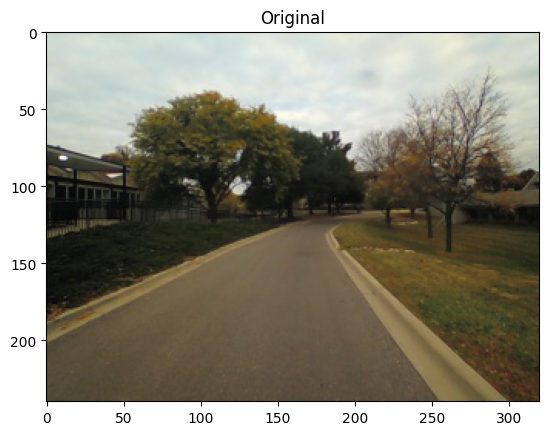

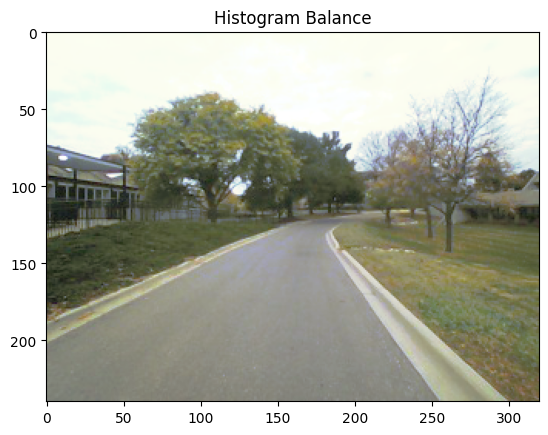

(240, 320, 3)


In [13]:
# Load histogram reference image
#img_ref = imread('/home/robofest/deep_steer/Data/221022_Histogram_Matching/histogram_ref.jpg')
img_ref = imread('/content/drive/MyDrive/Deep_Steer_2/Deep_Steer_2/histogram_ref.jpg')

# Preprocess the ref image
(ref_cdf_blue, ref_cdf_green, ref_cdf_red) = prep_ref_image(img_ref)
(RED_CDF_BLUE, REF_CDF_GREEN, REF_CDF_RED) = prep_ref_image(img_ref)

# Load sample image and show results
#img_sample = imread('/home/robofest/deep_steer/Data/221016_Deep_Steer_Data_Morning_Partly_Cloudy/A/route_A_179_0.00523599.jpg')
img_sample = imread('/content/drive/MyDrive/Deep_Steer_2/Deep_Steer_2/route_A_179_0.00523599.jpg')

# Perform histogram balance
#img_sample_balance = match_histograms(img_sample, ref_cdf_blue, ref_cdf_green, ref_cdf_red)
img_sample_balance = match_histogram(img_sample)

# Show results
plt.figure()
plt.imshow(img_sample)
plt.title('Original')
plt.show()

plt.figure()
plt.imshow(img_sample_balance)
plt.title('Histogram Balance')
plt.show()

imsave(os.path.join(output_path,'sample_image_original.jpg'), img_sample)
imsave(os.path.join(output_path,'sample_image_histogram_match.jpg'), img_sample_balance)
        
img_shape = img_ref.shape
print(img_shape)

### File Structure: Build training, validation and testing directories

In [ ]:
# Get all file paths
if( build_file_structure ) :
    # Initialize storage
    all_paths = []
    all_files = []

    # Loop folders
    for (DATA_PATH, ROUTES) in zip(DATA_PATHS, routes_train):

        print("Processing Data Path ", DATA_PATH)
        for route in ROUTES:
            # open folder
            os.chdir(os.path.join(DATA_PATH,route))
            filelist = glob.glob("route_%c_*.jpg" % route)
            print("Processing Route: %c (%d)" % (route,len(filelist) ))

            # Loop files
            skip_count = 0
            for file in filelist:
                if( skip_count % frame_skip == 0 ):
                    try:
                        img = cv2.imread(fname)
                        if img is None:
                            print('Issue with image file: ', fname)
                    except cv2.error as e:
                        print('Error with file %s' % fname)
                        
                    all_paths.append(os.path.join(DATA_PATH,route))
                    all_files.append(file)
                skip_count = skip_count + 1

    print('')
    print('Length of all_paths:', len(all_paths))
    print('Length of all_files:', len(all_files))

In [ ]:
# Create training, validation and testing lists
if( build_file_structure ):
    x_idx = np.arange(len(all_files))
    y_idx = np.arange(len(all_files))

    x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(x_idx, y_idx, test_size=0.2, random_state=1)
    x_train_idx, x_val_idx, y_train_idx, y_val_idx = train_test_split(x_train_idx, y_train_idx, test_size=0.2, random_state=1)

    print('')
    print('Training Images:   %6d / %6d ' % ( len(x_train_idx),len(y_train_idx) ) )
    print('Validation Images: %6d / %6d ' % ( len(x_val_idx),len(y_val_idx) ) )
    print('Testing Images:    %6d / %6d ' % ( len(x_test_idx),len(y_test_idx) ) )

In [ ]:
# Clear old files and create new ones
if( build_file_structure ):
    cmd_str = '/usr/bin/rm -r %s ' % os.path.join(BASE_DATA_PATH,'train/*')
    os.system(cmd_str)
    cmd_str = '/usr/bin/rm -r %s ' % os.path.join(BASE_DATA_PATH,'vali/*')
    os.system(cmd_str)
    cmd_str = '/usr/bin/rm -r %s ' % os.path.join(BASE_DATA_PATH,'test/*')
    os.system(cmd_str)    

In [ ]:
# Copy over files and build .csv files
if( build_file_structure ):
    for file_type, file_idx in zip(['train', 'vali', 'test'], [x_train_idx, x_val_idx, x_test_idx] ):
        print('Writing %s files...' % file_type)
        cmd_str = 'mkdir ' + os.path.join(BASE_DATA_PATH,file_type)
        os.system(cmd_str)
        csv_list = []
        for file_count in range(0,file_idx.shape[0]):          
            # Copy over file
            src_file = os.path.join(all_paths[file_idx[file_count]],all_files[file_idx[file_count]])
            dest_fname = '%d_%s' % (file_count,all_files[file_idx[file_count]])
            cmd_str = 'cp ' + src_file + ' ' + os.path.join(BASE_DATA_PATH,file_type,dest_fname)
            os.system(cmd_str)
            
            # Build .csv entry
            steer_angle_rad = float(dest_fname.split('_')[-1].replace('.jpg',''))
            #csv_list.append([file_count, steer_angle_rad, dest_fname])
            csv_list.append([file_count, steer_angle_rad, os.path.join(BASE_DATA_PATH,file_type,dest_fname)])
            
        # Write .csv file
        fname = os.path.join( BASE_DATA_PATH, file_type + '.csv' )
        print('   Writing: ', fname)
        with open(fname, 'w') as f:
            # Write header
            writer = csv.writer(f)
            writer.writerow(['id','steer_angle_rad','filename'])
            
            # Write the contents
            for row in csv_list:
                writer.writerow(row)

### Check file counts

In [ ]:
# Training images
os.chdir(os.path.join(BASE_DATA_PATH,'train'))
print(os.path.join(BASE_DATA_PATH,'train'))
filelist = glob.glob("*.jpg")
num_train_images = len(filelist)
print('Number of train files: %d' % num_train_images)

# Validation images
os.chdir(os.path.join(BASE_DATA_PATH,'vali'))
print(os.path.join(BASE_DATA_PATH,'vali'))
filelist = glob.glob("*.jpg")
num_vali_images = len(filelist)
print('Number of vali files: %d' % num_vali_images)

# Test images
os.chdir(os.path.join(BASE_DATA_PATH,'test'))
print(os.path.join(BASE_DATA_PATH,'test'))
filelist = glob.glob("*.jpg")
num_test_images = len(filelist)
print('Number of test files: %d' % num_test_images)

/home/robofest/deep_steer/Data/train
Number of train files: 23624
/home/robofest/deep_steer/Data/vali
Number of vali files: 5906
/home/robofest/deep_steer/Data/test
Number of test files: 7383


### Check images

In [ ]:
# Training images
os.chdir(os.path.join(BASE_DATA_PATH,'train'))
print(os.path.join(BASE_DATA_PATH,'train'))
filelist = glob.glob("*.jpg")
for fname in filelist:
    img = imread(fname)
    if img is None:
        print('Train.  Error with file %s' % fname)

# Validation images
os.chdir(os.path.join(BASE_DATA_PATH,'vali'))
print(os.path.join(BASE_DATA_PATH,'vali'))
filelist = glob.glob("*.jpg")
for fname in filelist:
    img = imread(fname)
    if img is None:
        print('Validation.  Error with file %s' % fname)

# Test images
os.chdir(os.path.join(BASE_DATA_PATH,'test'))
print(os.path.join(BASE_DATA_PATH,'test'))
filelist = glob.glob("*.jpg")
for fname in filelist:
    img = imread(fname)
    if img is None:
        print('Test.  Error with file %s' % fname)


/home/robofest/deep_steer/Data/train
/home/robofest/deep_steer/Data/vali
/home/robofest/deep_steer/Data/test


### Define data generators

In [ ]:
# Function to skip n frames and append to new dataframe
def skip_and_append(df, start_index):
    return df.iloc[start_index::hyperparameters['every_n'], :]

In [ ]:
# Create training dataframe
train_csv_file = os.path.join( BASE_DATA_PATH, 'train.csv' )
train_path = os.path.join( BASE_DATA_PATH, 'train' )
train_df = pd.read_csv(train_csv_file)
new_train_df = pd.DataFrame(columns=train_df.columns)
for i in range(hyperparameters['every_n']):
    new_train_df = new_train_df.append(skip_and_append(train_df, i))
train_df = new_train_df
print(train_path)
print(train_df)

# Create validate dataframe
vali_csv_file = os.path.join( BASE_DATA_PATH, 'vali.csv' )
vali_path = os.path.join( BASE_DATA_PATH, 'vali' )
vali_df = pd.read_csv(vali_csv_file)
print(vali_path)
print(vali_df)

# Create test dataframe
test_csv_file = os.path.join( BASE_DATA_PATH, 'test.csv' )
test_path = os.path.join( BASE_DATA_PATH, 'test' )
test_df = pd.read_csv(test_csv_file)
print(test_path)
print(test_df)

# Check histogram matching
pre_func_name = None
if( use_histogram_match ):
    pre_func_name = 'match_histogram'

# Build the resize datagen
datagen = ImageDataGenerator(rescale = 1./255)

# Build the train generator
train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_path,
        x_col="filename",
        y_col="steer_angle_rad",
        target_size=(img_shape[0],img_shape[1]),
        batch_size=hyperparameters['batchsize'],
        preprocessing_function=pre_func_name,
        class_mode='raw',
        shuffle=False)

# Build the validation generator
vali_generator = datagen.flow_from_dataframe(
        dataframe=vali_df,
        directory=vali_path,
        x_col="filename",
        y_col="steer_angle_rad",
        target_size=(img_shape[0],img_shape[1]),
        batch_size=hyperparameters['batchsize'],
        preprocessing_function=pre_func_name,
        class_mode='raw',
        shuffle=False)

# Build the test generator
test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_path,
        x_col="filename",
        y_col="steer_angle_rad",
        target_size=(img_shape[0],img_shape[1]),
        batch_size=1,
        preprocessing_function=pre_func_name,
        class_mode='raw',
        shuffle=False)

/home/robofest/deep_steer/Data/train
          id  steer_angle_rad  \
0          0         0.331613   
5          5         0.092503   
10        10         0.162316   
15        15        -0.005236   
20        20        -0.080285   
...      ...              ...   
23599  23599         0.286234   
23604  23604         0.741765   
23609  23609        -1.186820   
23614  23614        -0.089012   
23619  23619         1.029740   

                                                filename  
0      /home/robofest/deep_steer/Data/train/0_route_D...  
5      /home/robofest/deep_steer/Data/train/5_route_D...  
10     /home/robofest/deep_steer/Data/train/10_route_...  
15     /home/robofest/deep_steer/Data/train/15_route_...  
20     /home/robofest/deep_steer/Data/train/20_route_...  
...                                                  ...  
23599  /home/robofest/deep_steer/Data/train/23599_rou...  
23604  /home/robofest/deep_steer/Data/train/23604_rou...  
23609  /home/robofest/deep_steer/Da

### Load Data

In [ ]:
plt.hist(train_df['steer_angle_rad'],bins=40)
plt.title('Training Data')
plt.ylabel('Occurrences')
plt.xlabel('Steering Angle (rad)')
plt.savefig(os.path.join(output_path, 'data_histogram_training.jpg'))
plt.show()

plt.hist(vali_df['steer_angle_rad'],bins=40)
plt.title('Validation Data')
plt.ylabel('Occurrences')
plt.xlabel('Steering Angle (rad)')
plt.savefig(os.path.join(output_path, 'data_histogram_validation.jpg'))
plt.show()

plt.hist(test_df['steer_angle_rad'],bins=40)
plt.title('Test Data')
plt.ylabel('Occurrences')
plt.xlabel('Steering Angle (rad)')
plt.savefig(os.path.join(output_path, 'data_histogram_testing.jpg'))
plt.show()


### Load pretrained networks

In [15]:
if( flag_model_string == 'InceptionV3'): 
  # Read InceptionV3 Model
  base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=img_shape)
  base_model.trainable = False
  
if( flag_model_string == 'VGG16'):
  # Read VGG16 Model
  base_model = VGG16(weights='imagenet',
                     include_top=False, # do not use Dense of VGG16
                     input_shape=img_shape)
  base_model.trainable = False

if( flag_model_string == 'VGG19'):
  # Rear VGG19 Model
  base_model = VGG19(weights='imagenet',
                     include_top=False, # do not use Dense of VGG19
                     input_shape=img_shape)
  base_model.trainable = False

87910968/87910968 [==============================] - 4s 0us/step


In [19]:
if 'model' in locals():
  del model

# Build model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(hyperparameters['fc_size'], activation=hyperparameters['fc_activation']))
model.add(layers.Reshape((1, hyperparameters['fc_size'])))  # Reshape the output to (batch_size, 1, fc_size)
model.add(layers.SimpleRNN(128))  # Add SimpleRNN layer with 128 units
model.add(layers.Dense(1, kernel_initializer='normal'))
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001, momentum=0.9),
              loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 reshape_1 (Reshape)         (None, 1, 1024)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               147584    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

### Train Model

In [ ]:
if( train_model ):
    print('*************************')
    print('*** INITIAL TRAINING  ***')
    print('*************************')
    model.summary()

    # Set Early Stopping and Model Checkpoint callbacks - INITIAL BEST WEIGHTS
    callbacks_list = [ ModelCheckpoint(top_weights_file, monitor=hyperparameters["monitor"],
                                       verbose=1, save_best_only=True), \
                      EarlyStopping(monitor=hyperparameters["monitor"], patience=10, verbose=0) ]

    # train the model on the new data for a few epochs
    history1 = model.fit(train_generator,
                         steps_per_epoch= num_train_images / hyperparameters["batchsize"],
                         epochs=hyperparameters["epoch_finetune"],
                         callbacks=callbacks_list,
                         validation_data=vali_generator)

    print('*********************************')
    print('*** INITIAL TRAINING COMPLETE ***')
    print('***    START FINE TUNING      ***')
    print('*********************************')

    # Load the best results
    model.load_weights(top_weights_file)


    if( flag_model_string == 'InceptionV3'):
      model.layers[0].trainable = True
      # Turn off training the lower layers
      for layer in model.layers[0].layers[:249]:
          layer.trainable = False
      for layer in model.layers[0].layers[249:]:
          layer.trainable = True

    if( flag_model_string == 'VGG16' or flag_model_string == 'VGG19'):
      model.layers[0].trainable = True
      set_trainable = False
      for layer in model.layers[0].layers:
          if layer.name == 'block5_conv1':  # specify the first block to unfreeze here
              set_trainable = True
          if set_trainable:
              layer.trainable = True
          else:
              layer.trainable = False

    # Print Summary
    model.summary()

    # Set Early Stopping and Model Checkpoint callbacks - FINAL WEIGHTS
    callbacks_list = [ ModelCheckpoint(final_weights_file, monitor=hyperparameters["monitor"],
                                       verbose=1, save_best_only=True), \
                      EarlyStopping(monitor=hyperparameters["monitor"], patience=10, verbose=0)
    ]

    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001, momentum=0.9),
                  loss='mse', metrics=['mae'])

    history2 = model.fit(train_generator,
                         steps_per_epoch= num_train_images / hyperparameters["batchsize"],
                         epochs=hyperparameters["epoch_transfer"],
                         callbacks=callbacks_list,
                         validation_data=vali_generator)
else:
    if( flag_model_string == 'InceptionV3'):
      model.layers[0].trainable = True
      # Turn off training the lower layers
      for layer in model.layers[0].layers[:249]:
          layer.trainable = False
      for layer in model.layers[0].layers[249:]:
          layer.trainable = True

*************************
*** INITIAL TRAINING  ***
*************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
reshape (Reshape)            (None, 1, 1024)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               147584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 24,048,673
Trainable params: 2

2023-04-07 18:50:11.001854: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-07 18:50:14.385131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


3374/3374 [==============================] - 140s 40ms/step - loss: 0.2312 - mae: 0.2887 - val_loss: 0.1352 - val_mae: 0.2296

Epoch 00001: val_mae improved from inf to 0.22959, saving model to /home/robofest/deep_steer/Output/output_230407_regression_e5_batch_size_7/InceptionV3_top_weights.h5
Epoch 2/100
3374/3374 [==============================] - 132s 39ms/step - loss: 0.1195 - mae: 0.2284 - val_loss: 0.1010 - val_mae: 0.2568

Epoch 00002: val_mae did not improve from 0.22959
Epoch 3/100
3374/3374 [==============================] - 133s 39ms/step - loss: 0.0644 - mae: 0.1790 - val_loss: 0.0620 - val_mae: 0.1745

Epoch 00003: val_mae improved from 0.22959 to 0.17453, saving model to /home/robofest/deep_steer/Output/output_230407_regression_e5_batch_size_7/InceptionV3_top_weights.h5
Epoch 4/100
3374/3374 [==============================] - 132s 39ms/step - loss: 0.0471 - mae: 0.1536 - val_loss: 0.0409 - val_mae: 0.1478

Epoch 00004: val_mae improved from 0.17453 to 0.14776, saving mode

Epoch 35/100
3374/3374 [==============================] - 132s 39ms/step - loss: 0.0047 - mae: 0.0515 - val_loss: 0.0053 - val_mae: 0.0503

Epoch 00035: val_mae did not improve from 0.04875
Epoch 36/100
3374/3374 [==============================] - 132s 39ms/step - loss: 0.0049 - mae: 0.0518 - val_loss: 0.0058 - val_mae: 0.0521

Epoch 00036: val_mae did not improve from 0.04875
Epoch 37/100
3374/3374 [==============================] - 132s 39ms/step - loss: 0.0048 - mae: 0.0512 - val_loss: 0.0057 - val_mae: 0.0521

Epoch 00037: val_mae did not improve from 0.04875
Epoch 38/100
3374/3374 [==============================] - 132s 39ms/step - loss: 0.0047 - mae: 0.0503 - val_loss: 0.0052 - val_mae: 0.0501

Epoch 00038: val_mae did not improve from 0.04875
Epoch 39/100
3374/3374 [==============================] - 132s 39ms/step - loss: 0.0045 - mae: 0.0492 - val_loss: 0.0052 - val_mae: 0.0503

Epoch 00039: val_mae did not improve from 0.04875
Epoch 40/100
3374/3374 [==========================

3374/3374 [==============================] - 170s 50ms/step - loss: 2.5951e-04 - mae: 0.0119 - val_loss: 0.0012 - val_mae: 0.0184

Epoch 00059: val_mae did not improve from 0.01793
Epoch 60/100
3374/3374 [==============================] - 170s 50ms/step - loss: 2.4727e-04 - mae: 0.0119 - val_loss: 9.6813e-04 - val_mae: 0.0187

Epoch 00060: val_mae did not improve from 0.01793
Epoch 61/100
3374/3374 [==============================] - 170s 50ms/step - loss: 2.3744e-04 - mae: 0.0117 - val_loss: 0.0014 - val_mae: 0.0260

Epoch 00061: val_mae did not improve from 0.01793


In [20]:
if( train_model ):
    # Write the histories to file
    with open(train_hist_file, 'wb') as f:
      pickle.dump([history1.history, history2.history], f)
    hist1 = history1.history
    hist2 = history2.history
else:
    with open(train_hist_file, 'rb') as f:
        hist1, hist2 = pickle.load(f)

### Load the best final weights

In [ ]:
model.load_weights(final_weights_file) 

### Show training results

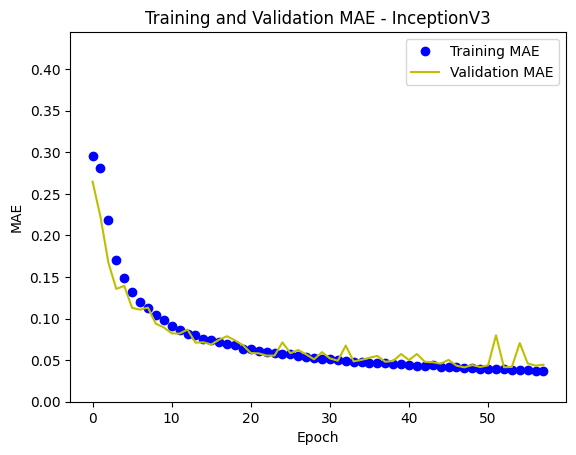

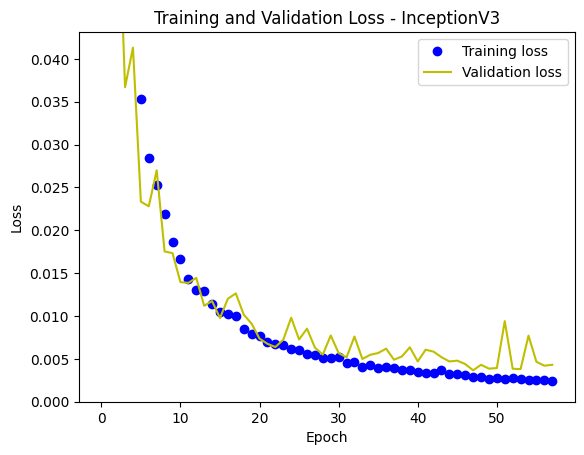

In [22]:
mae = hist1['mae']
val_mae = hist1['val_mae']
loss = hist1['loss']
val_loss = hist1['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'y', label='Validation MAE')
plt.ylim([0, 10*val_mae[-1] ])
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE - %s' % flag_model_string)
plt.legend()
plt.savefig(os.path.join(output_path, '%s_deep_steer_training_MAE_FE2' % flag_model_string))
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.ylim([0, 10*val_loss[-1] ])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - %s' % flag_model_string)
plt.legend()
plt.savefig(os.path.join(output_path, '%s_deep_steer_training_loss_FE2' % flag_model_string))
plt.show()

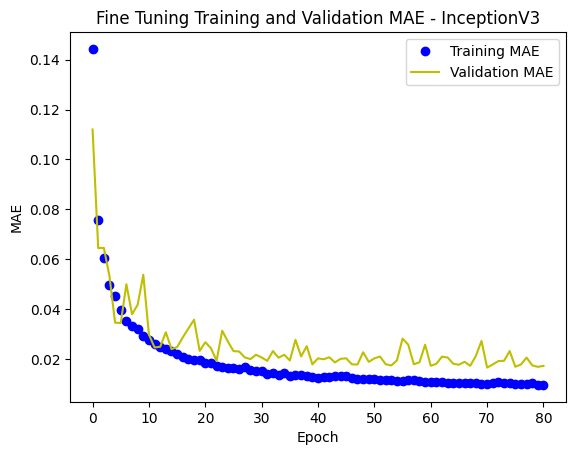

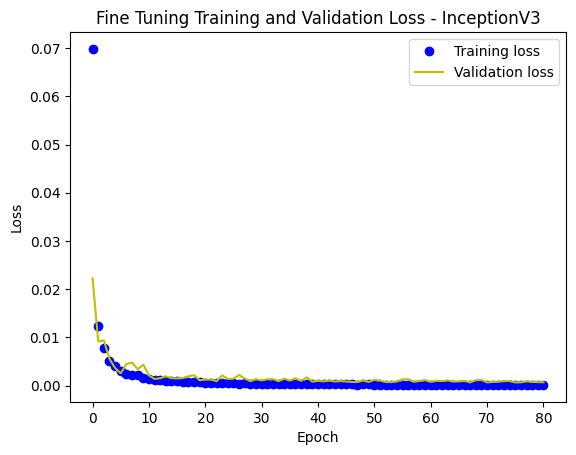

In [23]:
mae = hist2['mae']
val_mae = hist2['val_mae']
loss = hist2['loss']
val_loss = hist2['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'y', label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Fine Tuning Training and Validation MAE - %s' % flag_model_string)
plt.legend()
plt.savefig(os.path.join(output_path, '%s_deep_steer_training_MAE_FT' % flag_model_string))
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine Tuning Training and Validation Loss - %s' % flag_model_string)
plt.legend()
plt.savefig(os.path.join(output_path, '%s_deep_steer_training_loss_FT' % flag_model_string))
plt.show()


### Evaluate the test data

/home/robofest/deep_steer/Data/test/0_route_E_5921_0.418879.jpg 0.418879 [[0.39352638]]


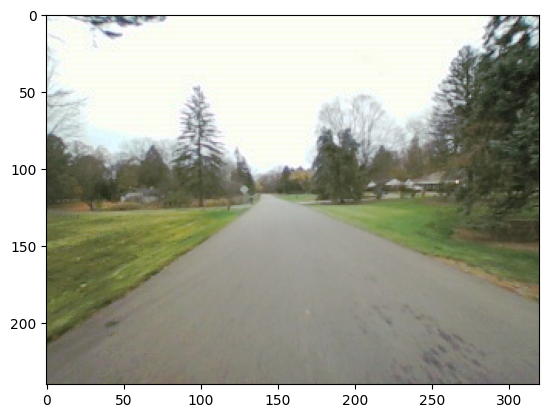

In [ ]:
if( eval_test_data ):
    # Load a sample image
    img = imread(test_df.filename[0])
    if( use_histogram_match ):
        img = match_histogram(img)
    img_nn = np.reshape(img,[1,240,320,3])
    img_nn = img_nn / 255.
    pred_swa = model.predict(img_nn)
    meas_swa = test_df.steer_angle_rad[0]
    print(test_df.filename[0], meas_swa, pred_swa)
    plt.imshow(img)
    plt.show()

### Examine the training data

In [ ]:
if( eval_train_data ):
    # Evaluate the training images
    pred_swa = []
    for idx in train_df.id:
        # Load a train image
        img = imread(train_df.filename[idx])
        if( use_histogram_match ):
            img = match_histogram(img)
        img_nn = np.reshape(img,[1,240,320,3])
        img_nn = img_nn / 255.
        pred_swa.append(model.predict(img_nn)[0][0])

    # Convert to numpy
    pred_swa = np.array(pred_swa)
    
    # Get the measured steering wheel angles
    meas_swa = train_df.steer_angle_rad.to_numpy()

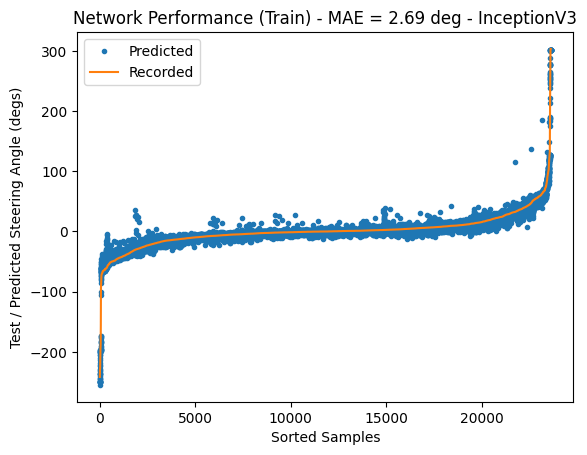

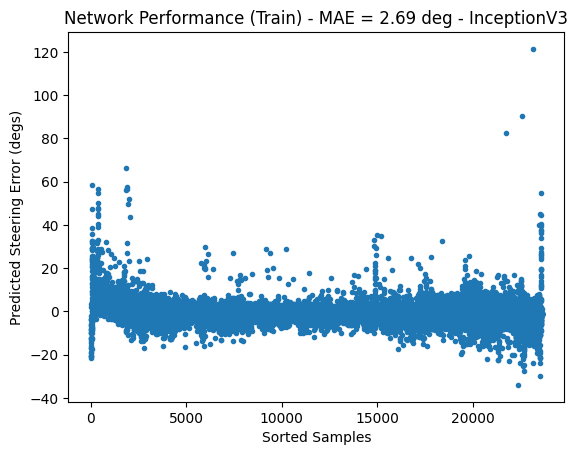

In [ ]:
if( eval_train_data ):
    test_steer_deg = np.rad2deg(meas_swa)
    pred_steer_deg = np.rad2deg(pred_swa)
    MAE = np.mean(np.abs(test_steer_deg-pred_steer_deg))
    idx = np.argsort(test_steer_deg)
    plt.plot(range(len(test_steer_deg)), pred_steer_deg[idx], '.', label='Predicted')
    plt.plot(range(len(test_steer_deg)), test_steer_deg[idx], label='Recorded')
    plt.title('Network Performance (Train) - MAE = %.2f deg - %s' % (MAE, flag_model_string) )
    #plt.title('Network Performance')
    plt.ylabel('Test / Predicted Steering Angle (degs)')
    plt.xlabel('Sorted Samples')
    plt.legend()
    plt.savefig(os.path.join(output_path, '%s_deep_steer_training_train_performance' % flag_model_string))
    plt.show()

    plt.plot(range(len(test_steer_deg)), pred_steer_deg.reshape(len(pred_steer_deg),)[idx]-test_steer_deg[idx], '.')
    plt.title('Network Performance (Train) - MAE = %.2f deg - %s' % (MAE, flag_model_string) )
    #plt.title('Network Performance')
    plt.ylabel('Predicted Steering Error (degs)')
    plt.xlabel('Sorted Samples')
    plt.savefig(os.path.join(output_path, '%s_deep_steer_training_train_performance_error' % flag_model_string))
    plt.show()

### Examine the validation data

In [ ]:
if( eval_vali_data ):
    # Evaluate the validation images
    pred_swa = []
    for idx in vali_df.id:
        # Load a validation image
        img = imread(vali_df.filename[idx])
        if( use_histogram_match ):
            img = match_histogram(img)
        img_nn = np.reshape(img,[1,240,320,3])
        img_nn = img_nn / 255.
        pred_swa.append(model.predict(img_nn)[0][0])

    # Convert to numpy
    pred_swa = np.array(pred_swa)
    
    # Get the measured steering wheel angles
    meas_swa = vali_df.steer_angle_rad.to_numpy()

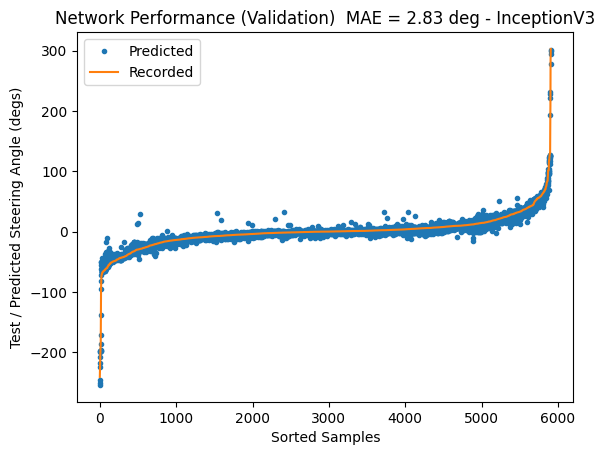

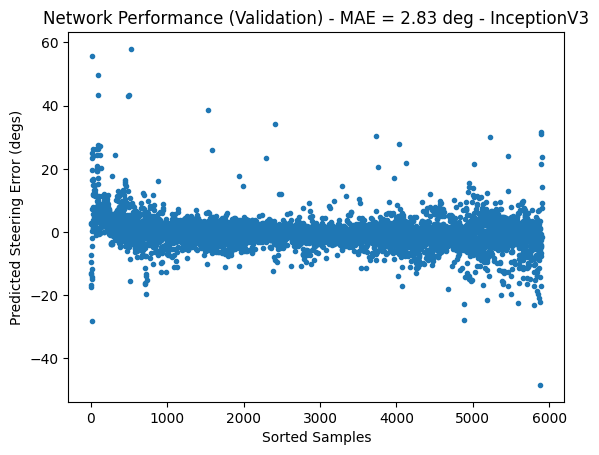

In [ ]:
if( eval_vali_data ):
    test_steer_deg = np.rad2deg(meas_swa)
    pred_steer_deg = np.rad2deg(pred_swa)
    MAE = np.mean(np.abs(test_steer_deg-pred_steer_deg))
    idx = np.argsort(test_steer_deg)
    plt.plot(range(len(test_steer_deg)), pred_steer_deg[idx], '.', label='Predicted')
    plt.plot(range(len(test_steer_deg)), test_steer_deg[idx], label='Recorded')
    plt.title('Network Performance (Validation)  MAE = %.2f deg - %s' % (MAE, flag_model_string) )
    plt.ylabel('Test / Predicted Steering Angle (degs)')
    plt.xlabel('Sorted Samples')
    plt.legend()
    plt.savefig(os.path.join(output_path, '%s_deep_steer_training_vali_performance' % flag_model_string))
    plt.show()

    plt.plot(range(len(test_steer_deg)), pred_steer_deg.reshape(len(pred_steer_deg),)[idx]-test_steer_deg[idx], '.')
    plt.title('Network Performance (Validation) - MAE = %.2f deg - %s' % (MAE, flag_model_string) )
    plt.ylabel('Predicted Steering Error (degs)')
    plt.xlabel('Sorted Samples')
    plt.savefig(os.path.join(output_path, '%s_deep_steer_training_vali_performance_error' % flag_model_string))
    plt.show()

### Examine the test data (extracted from training data)

In [ ]:
if( eval_test_data ):
    # Evaluate the test images
    pred_swa = []
    for idx in test_df.id:
        # Load a test image
        img = imread(test_df.filename[idx])
        if( use_histogram_match ):
            img = match_histogram(img)
        img_nn = np.reshape(img,[1,240,320,3])
        img_nn = img_nn / 255.
        pred_swa.append(model.predict(img_nn)[0][0])

    # Convert to numpy
    pred_swa = np.array(pred_swa)
    
    # Get the measured steering wheel angles
    meas_swa = test_df.steer_angle_rad.to_numpy()

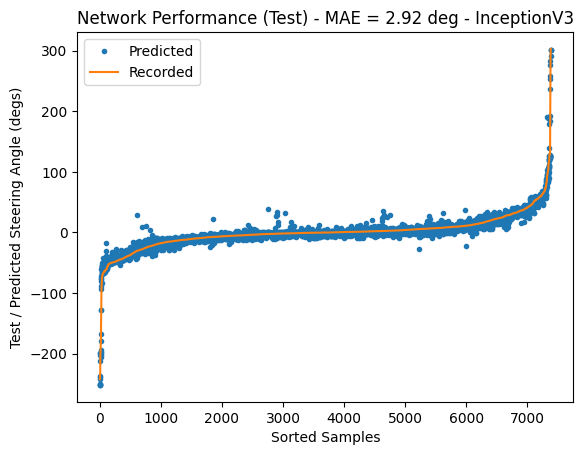

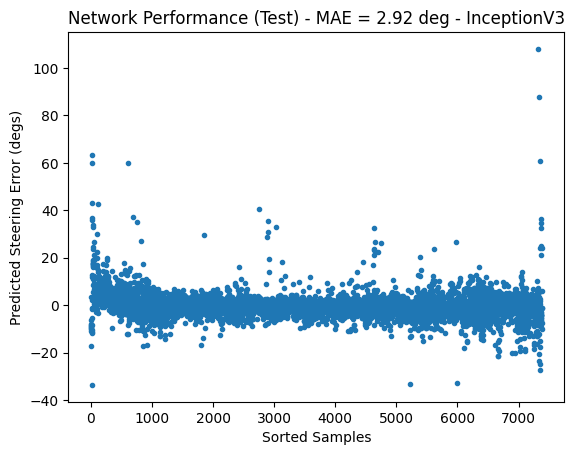

In [ ]:
if( eval_test_data ):
    test_steer_deg = np.rad2deg(meas_swa)
    pred_steer_deg = np.rad2deg(pred_swa)
    MAE = np.mean(np.abs(test_steer_deg-pred_steer_deg))
    idx = np.argsort(test_steer_deg)
    plt.plot(range(len(test_steer_deg)), pred_steer_deg[idx], '.', label='Predicted')
    plt.plot(range(len(test_steer_deg)), test_steer_deg[idx], label='Recorded')
    plt.title('Network Performance (Test) - MAE = %.2f deg - %s' % (MAE, flag_model_string) )
    plt.ylabel('Test / Predicted Steering Angle (degs)')
    plt.xlabel('Sorted Samples')
    plt.legend()
    plt.savefig(os.path.join(output_path, '%s_deep_steer_training_test_performance' % flag_model_string))
    plt.show()

    plt.plot(range(len(test_steer_deg)), pred_steer_deg.reshape(len(pred_steer_deg),)[idx]-test_steer_deg[idx], '.')
    plt.title('Network Performance (Test) - MAE = %.2f deg - %s' % (MAE, flag_model_string) )
    plt.ylabel('Predicted Steering Error (degs)')
    plt.xlabel('Sorted Samples')
    plt.savefig(os.path.join(output_path, '%s_deep_steer_training_test_performance_error' % flag_model_string))
    plt.show()

## Evaluate Test Routes

In [ ]:
if( eval_test_course_data ):
    # Initialize storage
    pred_swa_rad = []
    meas_swa_rad = []

    # Loop folders
    for (DATA_PATH, ROUTES) in zip(DATA_PATHS, routes_test):

        print("Processing Data Path ", DATA_PATH)
        for route in ROUTES:
            # open folder
            os.chdir(os.path.join(DATA_PATH,route))
            filelist = glob.glob("route_%c_*.jpg" % route)
            print("Processing Test Course Route: %c (%d)" % (route,len(filelist) ))

            # Loop files
            for file in filelist:
                img = imread(file)
                if( use_histogram_match ):
                    img = match_histogram(img)
                img_nn = np.reshape(img,[1,240,320,3])
                img_nn = img_nn / 255.
                pred_swa_rad.append(model.predict(img_nn)[0][0])
                meas_swa_rad.append(float(file.split('_')[-1].replace('.jpg','')))

    # Convert to numpy
    pred_swa_rad = np.array(pred_swa_rad)
    meas_swa_rad = np.array(meas_swa_rad)

Processing Data Path  /home/robofest/deep_steer/Data/221025_Road_Center_Morning_Slightly_Cloudy
Processing Test Course Route: B (7692)
Processing Data Path  /home/robofest/deep_steer/Data/221105_Road_Center_Data_Morning_Cloudy_On_Off_Campus


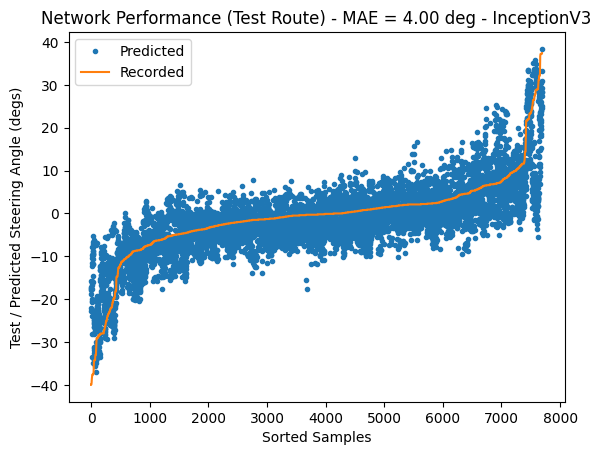

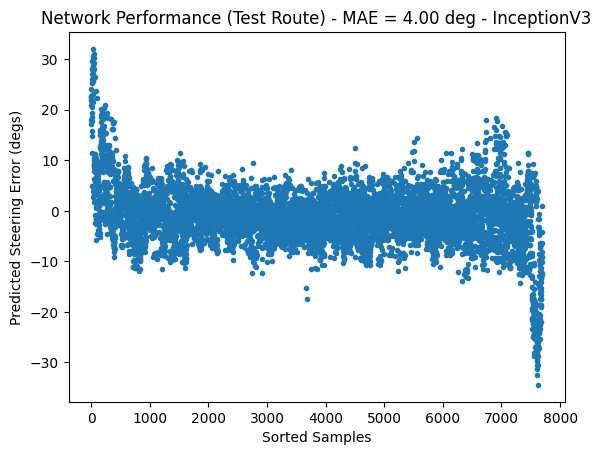

In [ ]:
if( eval_test_course_data ):
    test_steer_deg = np.rad2deg(meas_swa_rad)
    pred_steer_deg = np.rad2deg(pred_swa_rad)
    MAE = np.mean(np.abs(test_steer_deg-pred_steer_deg))
    idx = np.argsort(test_steer_deg)
    plt.plot(range(test_steer_deg.size), pred_steer_deg[idx], '.', label='Predicted')
    plt.plot(range(test_steer_deg.size), test_steer_deg[idx], label='Recorded')
    plt.title('Network Performance (Test Route) - MAE = %.2f deg - %s' % (MAE, flag_model_string) )
    plt.ylabel('Test / Predicted Steering Angle (degs)')
    plt.xlabel('Sorted Samples')
    plt.legend()
    plt.savefig(os.path.join(output_path, '%s_deep_steer_test_course_performance' % flag_model_string))
    plt.show()

    plt.plot(range(len(test_steer_deg)), pred_steer_deg.reshape(len(pred_steer_deg),)[idx]-test_steer_deg[idx], '.')
    plt.title('Network Performance (Test Route) - MAE = %.2f deg - %s' % (MAE, flag_model_string) )
    plt.ylabel('Predicted Steering Error (degs)')
    plt.xlabel('Sorted Samples')
    plt.savefig(os.path.join(output_path, '%s_deep_steer_test_course_performance_error' % flag_model_string))
    plt.show()

In [ ]:
MAE = np.mean(np.abs(test_steer_deg-pred_steer_deg))
print('Test Course MAE = %.2f deg' % MAE) 

Test Course MAE = 4.00 deg


In [ ]:
end_time = time.time()

print("Time taken: ", end_time - start_time, "seconds")

Time taken:  19240.302401781082 seconds
